In [695]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In this project, I will use Linear Regression to determine the relationship of the Inflation and Interest rates with the S&P500.

In [659]:
sp500 = pd.read_csv (r'SP500.csv')
inflation=pd.read_csv (r'T10YIE.csv')
interest=pd.read_csv (r'DFF.csv')

# Data Cleaning

The following are the summaries of each dataset.

In [431]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    1305 non-null   object
 1   SP500   1305 non-null   object
dtypes: object(2)
memory usage: 20.5+ KB


In [531]:
inflation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    1305 non-null   object
 1   T10YIE  1305 non-null   object
dtypes: object(2)
memory usage: 20.5+ KB


In [491]:
interest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    1827 non-null   object 
 1   DFF     1827 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.7+ KB


The data has some entries that only have periods.  The following replaces the entries that have only periods with the mean of the data.

In [139]:
def mean_replace(column,df,value):
    l=[]
    for i in column:
        if i!=value:
            l.append(float(i))
    for i in column:
        if i==value:
            df=df.replace(value,np.mean(l))

In [140]:
mean_replace(sp500.SP500,sp500,'.')

In [ ]:
mean_replace(inflation.T10YIE,inflation,'.')

In [ ]:
mean_replace(interest.DFF,interest,'.')

In [542]:
sp=np.array([float(i) for i in sp500.SP500])
infl=np.array([float(i) for i in inflation.T10YIE])
inte=np.array([float(i) for i in interest.DFF])[522:]

# Feature Engineering

Inflation is close to being normally distributed and Interest is not.

Text(0.5, 1.0, 'Inflation Rate Distribution')

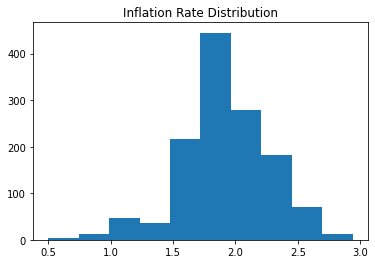

In [530]:
plt.hist(infl)
plt.title('Inflation Rate Distribution')

Text(0.5, 1.0, 'Interest Rate Distribution')

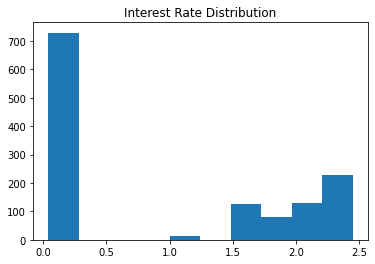

In [528]:
plt.hist(inte)
plt.title('Interest Rate Distribution')

Use min max scaling to normalize the distributions.

In [715]:
ifn=[(i-min(infl))/(max(infl)-min(infl)) for i in infl]
itn=[(i-min(infl))/(max(infl)-min(infl)) for i in inte]

H0:The means of Inflation and Interest are the same.
H1:The means of Inflation and Interest are not the same.  
The p-value of the z-test indicates that Inflation and Interest are statistically distinct from eachother.

In [699]:
sm.stats.ztest(ifn, itn, alternative='two-sided')

(array([16.65105685]), array([2.97305142e-62]))

In [706]:
df=pd.DataFrame({'SP500':sp,'Interest':np.ravel(itn),'Inflation':np.ravel(ifn)})

There is no significant multicollinearity amoung Inflation and Interest rates. 

In [704]:
df.corr()

,SP500,Interest,Inflation
SP500,1.000000,-0.678821,0.583123
Interest,-0.678821,1.000000,0.072239
Inflation,0.583123,0.072239,1.000000


# Modeling

In [705]:
model=sm.formula.ols('SP500~Inflation+Interest+Inflation*Interest', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SP500   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     2744.
Date:                Mon, 28 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:23:44   Log-Likelihood:                -9063.0
No. Observations:                1305   AIC:                         1.813e+04
Df Residuals:                    1301   BIC:                         1.815e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1886.8407     30.696     61.469      0.000    1826.622    1947.060
Inflation           3006.5329     50.498     59.537      0.000    2907.466    3105.600
Interest            -750.1184    136.994     -5.476      0.000   -1018.871    -481.366
Inflation:Interest  -702.7069    226.498     -3.102      0.002   -1147.048    -258.366
==============================================================================
Omnibus:                       93.353   Durbin-Watson:                   0.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              359.487
Skew:                          -0.230   Prob(JB):                     8.68e-79
Kurtosis:                       5.530   Cond. No.                         47.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model R squared is a good score.  With a critical value of .05, both Inflation and Interest have statistically significant p-values.  Inflation has a positive effect and Interest has a negative effect on the S&P500.  For every one unit increase of Inflation, the S&P500 increases by 3006.5329.  For every one unit increase of Interest, the S&P500 decreases by 750.1184.  For every one unit increase in the interaction term, the S&P500 decreases by 702.7069.

The F-statistic null hypothesis is the regression coefficients are zero.  The F statistic p-value shows that the coeficiants are significant.  

The assumption of independent residuals Durbin-Watson test is ouside the range of 1 to 2, but very close to 1.

The assumption of normality of the residuals Jarque-Bera test has a null hypothesis of normality of the residuals.  After normalizing the data with min max scaling the residuals are still not normally distributed.

In [691]:
sm.stats.diagnostic.het_breuschpagan(model.resid, model.model.exog)[:2]

(53.695065619809355, 1.303302857150924e-11)

The assumption of homoscedasticity Breusch-Pagan test has a null hypothesis that the residual variances are all equal.  The p-value does not pass this test.

The Anova model F statistic score shows that the variation between group means is larger than the variation within group means and that there are few errors. The p-values indicate that both Inflation and Interest are statistically significant from and have an effect on the S&P500.  The F score for the interaction term confirms that the impact of the independant variable depends on the level of the other independant variable.

In [717]:
sm.stats.anova_lm(model,typ=2)

,sum_sq,df,F,PR(>F)
Inflation,2.422174e+08,1.0,3829.712609,0.00000
Interest,3.150326e+08,1.0,4980.997570,0.00000
Inflation:Interest,6.087786e+05,1.0,9.625432,0.00196
Residual,8.228420e+07,1301.0,NaN,NaN


In [707]:
x=df.drop('SP500',axis=1)
y_hat=model.predict(x)

The RMSE:.

In [708]:
sm.tools.eval_measures.rmse(df.SP500,y_hat)

251.10361647334568